# 2.bis. Basic GCN classification (MXNet)

### About this notebook

This notebook was used in the 50.039 Deep Learning course at the Singapore University of Technology and Design.

**Author:** Matthieu DE MARI (matthieu_demari@sutd.edu.sg)

**Version:** 1.1 (28/03/2022)

**Requirements:**
- Python 3 (tested on v3.9.6)
- Matplotlib (tested on v3.5.1)
- Networkx
- Numpy (tested on v1.22.1)
- Pandas
- Sklearn

In [1]:
import matplotlib.pyplot as plt

import mxnet.ndarray as nd
from mxnet import autograd, init
from mxnet.initializer import One, Uniform, Xavier
from mxnet.gluon import HybridBlock, Trainer
from mxnet.gluon.loss import SigmoidBinaryCrossEntropyLoss
from mxnet.gluon.nn import HybridSequential, Activation
from mxnet.ndarray import array
from mxnet.ndarray import sum as ndsum
from mxnet.random import seed as mxn_seed

from networkx import read_edgelist, set_node_attributes
from networkx import karate_club_graph, to_numpy_matrix
from networkx import shortest_path_length

import numpy as np
from numpy import array
from numpy.random import seed as np_seed

from pandas import read_csv, Series

from sklearn.metrics import classification_report

## Retrieve graph info

In [2]:
from networkx import karate_club_graph
G = karate_club_graph()

In [3]:
def define_nodes_parameters(G):
    
    # Initialize nodes parameters
    nodes_parameters = {}

    # Nodes number
    nodes_parameters['nodes_number'] = 0

    # Nodes names
    nodes_parameters['nodes_names'] = []

    # Nodes features
    nodes_parameters['nodes_features'] = []

    # Labels list
    nodes_parameters['labels_list'] = []

    # Nodes labels
    nodes_parameters['nodes_labels'] = []

    # Read nodes from graph
    for node_key, node_value in G._node.items():
        nodes_parameters['nodes_number'] += 1
        nodes_parameters['nodes_names'].append(node_key)
        node_value = node_value['club']
        if not node_value in nodes_parameters['labels_list']:
            nodes_parameters['labels_list'].append(node_value)
        nodes_parameters['nodes_labels'].append(nodes_parameters['labels_list'].index(node_value))

    # Return
    return nodes_parameters

In [4]:
nodes_parameters = define_nodes_parameters(G)
print(nodes_parameters)

{'nodes_number': 34, 'nodes_names': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33], 'nodes_features': [], 'labels_list': ['Mr. Hi', 'Officer'], 'nodes_labels': [0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]}


In [5]:
def define_edges_parameters(G, nodes_number):
    
    # Initialize edges parameters
    edges_parameters = {}

    # Edges number
    edges_parameters['edges_number'] = len(list(G.edges().keys()))

    # Edges names
    edges_parameters['edges_names'] = list(G.edges().keys())

    # Adjacency matrix
    edges_parameters['adjacency_matrix'] = np.zeros([nodes_number, nodes_number])

    # Degree matrix
    edges_parameters['degree_matrix'] = np.zeros([nodes_number, nodes_number])

    # Read edges and update adjacency matrix and degree matrix
    for edge in edges_parameters['edges_names']:
        node1, node2 = edge
        edges_parameters['adjacency_matrix'][node1, node2] = 1
        edges_parameters['adjacency_matrix'][node2, node1] = 1
        edges_parameters['degree_matrix'][node1, node1] += 1
        edges_parameters['degree_matrix'][node2, node2] += 1

    # Return
    return edges_parameters

In [6]:
edges_parameters = define_edges_parameters(G, nodes_number = nodes_parameters['nodes_number'])
print(edges_parameters)

{'edges_number': 78, 'edges_names': [(0, 1), (0, 2), (0, 3), (0, 4), (0, 5), (0, 6), (0, 7), (0, 8), (0, 10), (0, 11), (0, 12), (0, 13), (0, 17), (0, 19), (0, 21), (0, 31), (1, 2), (1, 3), (1, 7), (1, 13), (1, 17), (1, 19), (1, 21), (1, 30), (2, 3), (2, 7), (2, 8), (2, 9), (2, 13), (2, 27), (2, 28), (2, 32), (3, 7), (3, 12), (3, 13), (4, 6), (4, 10), (5, 6), (5, 10), (5, 16), (6, 16), (8, 30), (8, 32), (8, 33), (9, 33), (13, 33), (14, 32), (14, 33), (15, 32), (15, 33), (18, 32), (18, 33), (19, 33), (20, 32), (20, 33), (22, 32), (22, 33), (23, 25), (23, 27), (23, 29), (23, 32), (23, 33), (24, 25), (24, 27), (24, 31), (25, 31), (26, 29), (26, 33), (27, 33), (28, 31), (28, 33), (29, 32), (29, 33), (30, 32), (30, 33), (31, 32), (31, 33), (32, 33)], 'adjacency_matrix': array([[0., 1., 1., ..., 1., 0., 0.],
       [1., 0., 1., ..., 0., 0., 0.],
       [1., 1., 0., ..., 0., 1., 0.],
       ...,
       [1., 0., 0., ..., 0., 1., 1.],
       [0., 0., 1., ..., 1., 0., 1.],
       [0., 0., 0., ...

## Define Hybrid GCN block

In [7]:
class GCN_Kipf_Block(HybridBlock):
    
    def __init__(self, A, input_units, output_units, activation_fun = 'relu', **kwargs):
        
        # Reuse __init__ from HybridBlock
        super().__init__(**kwargs)
        
        # Define N_hat for Kipf propagation rule
        I = nd.eye(A.shape[0])
        A_hat = nd.array(A) + I
        D = nd.sum(A_hat, axis=0)
        D_inv = D**-0.5
        D_inv = nd.diag(D_inv)
        N_hat = D_inv * A_hat * D_inv
        
        # Input and output units
        self.input_units, self.output_units = input_units, output_units
        
        # Define context manager
        with self.name_scope():
            
            # Add N_hat
            self.N_hat = self.params.get_constant('N_hat', N_hat)
            
            # Add weigths W
            self.W = self.params.get('W', shape=(self.input_units, self.output_units))
            
            # Add activation function
            if activation_fun == 'identity':
                self.activation_fun = lambda x: x
            else:
                self.activation_fun = Activation(activation_fun)

    def hybrid_forward(self, F, X, N_hat, W):
        
        # Define forward propagation rule for GCN_Kipf_Block
        return self.activation_fun(F.dot(F.dot(N_hat, X), W))

In [8]:
class Logistic_Regressor(HybridBlock):
    
    def __init__(self, input_units, **kwargs):
        
        # Reuse __init__ from HybridBlock
        super().__init__(**kwargs)
        
        # Define context manager
        with self.name_scope():
            
            # Add weights w
            self.w = self.params.get('w', shape=(1, input_units))
            
            # Add bias b
            self.b = self.params.get('b', shape=(1, 1))

    def hybrid_forward(self, F, X, w, b):
        
        # Define forward propagation rule for GCN_Kipf_Block
        # (Adjust shape of b to comply with MXnet addition API)
        return F.sigmoid(F.dot(X, w, transpose_b = True) \
                + F.broadcast_axis(b, axis=(0,1), size=(34, 1)))

In [9]:
def build_features(A, X):
    
    # List of hidden layers as tuples (number of units, activation function)
    layers_list = [(4, 'relu'), (2, 'relu')]
    input_units = X.shape[1]
    
    # Define embedding model as HybridSequential
    emb_model = HybridSequential()
    with emb_model.name_scope():
        for i, (layer_size, activation_fun) in enumerate(layers_list):
            
            # Add GCN_Kipf_Block layer with parameters
            layer = GCN_Kipf_Block(A, input_units = input_units, \
                                   output_units = layer_size, \
                                   activation_fun = activation_fun)
            emb_model.add(layer)
            input_units = layer_size
            
    return emb_model, input_units

In [10]:
def build_model(A, X):
    
    # Define embedding model as HybridSequential
    model = HybridSequential()
    input_units = X.shape[1]

    with model.name_scope():
        
        # Add embedding model
        emb_model, output_units = build_features(A, X)
        model.add(emb_model)
        
        # Add classifier
        classifier = Logistic_Regressor(output_units)
        model.add(classifier)
        
    # Hybridize layers
    model.hybridize()
    
    # Initialize weights as Normal [0,1]
    #model.initialize(Uniform(1))
    model.initialize(init=init.Normal(sigma=0.01))

    return model, emb_model

In [11]:
X1 = nd.eye(nodes_parameters['nodes_number'])
model1, emb_model1 = build_model(edges_parameters['adjacency_matrix'], X1)
Y1 = model1(X1)

In [12]:
print(X1)


[[1. 0. 0. ... 0. 0. 0.]
 [0. 1. 0. ... 0. 0. 0.]
 [0. 0. 1. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 1. 0. 0.]
 [0. 0. 0. ... 0. 1. 0.]
 [0. 0. 0. ... 0. 0. 1.]]
<NDArray 34x34 @cpu(0)>


In [13]:
print(Y1)


[[0.49211118]
 [0.49211118]
 [0.49211118]
 [0.49211118]
 [0.49211118]
 [0.49211118]
 [0.49211118]
 [0.49211118]
 [0.49211118]
 [0.49211118]
 [0.49211118]
 [0.49211118]
 [0.49211118]
 [0.49211124]
 [0.49211118]
 [0.49211118]
 [0.49211118]
 [0.49211118]
 [0.49211118]
 [0.49211118]
 [0.49211118]
 [0.49211124]
 [0.49211118]
 [0.49211118]
 [0.49211118]
 [0.49211118]
 [0.49211118]
 [0.49211118]
 [0.49211124]
 [0.49211118]
 [0.49211118]
 [0.49211118]
 [0.49211118]
 [0.49211118]]
<NDArray 34x1 @cpu(0)>


In [14]:
X2 = nd.zeros((nodes_parameters['nodes_number'], 2))
node_distance_mrhi = shortest_path_length(G, target = 33)
node_distance_officer = shortest_path_length(G, target = 0)
for node in G.nodes():
    X2[node][0] = node_distance_mrhi[node]
    X2[node][1] = node_distance_officer[node]
X2_comb = nd.concat(X1, X2)
model2, emb_model2 = build_model(edges_parameters['adjacency_matrix'], X2_comb)
Y2 = model2(X2_comb)

In [15]:
print(X2)


[[2. 0.]
 [2. 1.]
 [2. 1.]
 [2. 1.]
 [3. 1.]
 [3. 1.]
 [3. 1.]
 [3. 1.]
 [1. 1.]
 [1. 2.]
 [3. 1.]
 [3. 1.]
 [3. 1.]
 [1. 1.]
 [1. 3.]
 [1. 3.]
 [4. 2.]
 [3. 1.]
 [1. 3.]
 [1. 1.]
 [1. 3.]
 [3. 1.]
 [1. 3.]
 [1. 3.]
 [2. 2.]
 [2. 2.]
 [1. 3.]
 [1. 2.]
 [1. 2.]
 [1. 3.]
 [1. 2.]
 [1. 1.]
 [1. 2.]
 [0. 2.]]
<NDArray 34x2 @cpu(0)>


In [16]:
print(X1)
print(X2_comb)


[[1. 0. 0. ... 0. 0. 0.]
 [0. 1. 0. ... 0. 0. 0.]
 [0. 0. 1. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 1. 0. 0.]
 [0. 0. 0. ... 0. 1. 0.]
 [0. 0. 0. ... 0. 0. 1.]]
<NDArray 34x34 @cpu(0)>

[[1. 0. 0. ... 0. 2. 0.]
 [0. 1. 0. ... 0. 2. 1.]
 [0. 0. 1. ... 0. 2. 1.]
 ...
 [0. 0. 0. ... 0. 1. 1.]
 [0. 0. 0. ... 0. 1. 2.]
 [0. 0. 0. ... 1. 0. 2.]]
<NDArray 34x36 @cpu(0)>


In [17]:
print(Y2)


[[0.5012415 ]
 [0.5012415 ]
 [0.5012415 ]
 [0.5012415 ]
 [0.5012415 ]
 [0.5012415 ]
 [0.5012415 ]
 [0.5012415 ]
 [0.5012415 ]
 [0.50124145]
 [0.5012415 ]
 [0.5012414 ]
 [0.50124145]
 [0.5012415 ]
 [0.5012415 ]
 [0.50124145]
 [0.50124145]
 [0.50124145]
 [0.5012415 ]
 [0.5012415 ]
 [0.5012415 ]
 [0.50124145]
 [0.50124145]
 [0.5012415 ]
 [0.5012415 ]
 [0.5012415 ]
 [0.5012415 ]
 [0.5012415 ]
 [0.5012415 ]
 [0.5012415 ]
 [0.5012415 ]
 [0.5012415 ]
 [0.5012415 ]
 [0.5012415 ]]
<NDArray 34x1 @cpu(0)>


## Define Trainer and Predictor

In [18]:
def train(model, emb_model, X, X_train, Y_train, epochs, display = True):
    
    # Loss function as cross entropy
    cross_entropy = SigmoidBinaryCrossEntropyLoss(from_sigmoid = True)
    
    # Initialize trainer with SGD optimizer, lr = 0.001, momentum = 1
    trainer = Trainer(model.collect_params(), 'sgd', \
                      {'learning_rate': 0.001, 'momentum': 1})
    
    # Initialize embedding representations
    emb_representations = [emb_model(X).asnumpy()]
    
    # Iterate on epochs
    for e in range(1, epochs + 1):
        
        # Initialize loss
        cum_loss = 0
        cum_preds = []
        
        # Iterate over training samples
        for i, x in enumerate(X_train.flatten()):
            Y = nd.array(Y_train)[i]
            with autograd.record():
                preds = model(X)[x]
                loss = cross_entropy(preds, Y)
            
            # Backward propagation
            loss.backward()
            
            # Step
            trainer.step(1)
            
            # Aggregate losses
            cum_loss += loss.asscalar()
            cum_preds += [preds.asscalar()]

        # Add to embeddings representations 
        emb_representations.append(emb_model(X).asnumpy())
        
        # Display training progress
        fac = 20
        if (e % (epochs//fac)) == 0 and display:
            #print("-----")
            print(f"Epoch {e}/{epochs} -- Loss: {cum_loss: .4f}")
            #print(cum_preds)
            #print(Y_train)
            
    return emb_representations

## Data splitting and training

In [19]:
def define_data_split(nodes_parameters, split = 0.3):
    
    # Initialize X_train, Y_train, X_test, Y_test
    X_train, Y_train, X_test, Y_test = [], [], [], []
    
    # Iterate on nodes
    for node_index in range(nodes_parameters['nodes_number']):
        
        # Retrieve node features and label
        #node_feature = nodes_parameters['nodes_features'][node_index]
        node_feature = nodes_parameters['nodes_names'][node_index]
        node_label = nodes_parameters['nodes_labels'][node_index]
        
        if node_index == 0 or node_index == 33:
            # If node is Mr. Hi (0) or Officer (33), add to training
            X_train.append([node_feature])
            Y_train.append(node_label)
        elif np.random.random() < split:
            # Otherwise, roll a random to decide on train/test set assignment
            X_train.append([node_feature])
            Y_train.append(node_label)
        else:
            X_test.append([node_feature])
            Y_test.append(node_label)
        
    return np.array(X_train), np.array(Y_train), np.array(X_test), np.array(Y_test)

In [20]:
# Fix seed for reproducibility
np_seed(10)
mxn_seed(10)

In [21]:
#X_train, Y_train, X_test, Y_test = define_data_split(nodes_parameters, split = 0.3)
X_train, Y_train, X_test, Y_test = define_data_split(nodes_parameters, split = 0.5)
print(X_train)
print(Y_train)
print(X_test)
print(Y_test)

[[ 0]
 [ 2]
 [ 5]
 [ 6]
 [ 7]
 [ 9]
 [10]
 [13]
 [18]
 [22]
 [23]
 [25]
 [26]
 [33]]
[0 0 0 0 0 1 0 0 1 1 1 1 1 1]
[[ 1]
 [ 3]
 [ 4]
 [ 8]
 [11]
 [12]
 [14]
 [15]
 [16]
 [17]
 [19]
 [20]
 [21]
 [24]
 [27]
 [28]
 [29]
 [30]
 [31]
 [32]]
[0 0 0 0 0 0 1 1 0 0 0 1 0 1 1 1 1 1 1 1]


## Build model (no useful features)

In [22]:
# Fix seed for reproducibility
np_seed(27)
mxn_seed(27)

In [23]:
# Build model
model1, emb_model1 = build_model(edges_parameters['adjacency_matrix'], X1)

In [24]:
emb_representations_1 = train(model1, emb_model1, X1, X_train, Y_train, epochs = 2000)

Epoch 100/2000 -- Loss:  9.6786
Epoch 200/2000 -- Loss:  9.7509
Epoch 300/2000 -- Loss:  9.6821
Epoch 400/2000 -- Loss:  9.7507
Epoch 500/2000 -- Loss:  9.6903
Epoch 600/2000 -- Loss:  9.7451
Epoch 700/2000 -- Loss:  4.9391
Epoch 800/2000 -- Loss:  3.0401
Epoch 900/2000 -- Loss:  3.0456
Epoch 1000/2000 -- Loss:  3.0516
Epoch 1100/2000 -- Loss:  3.0197
Epoch 1200/2000 -- Loss:  3.0338
Epoch 1300/2000 -- Loss:  3.0496
Epoch 1400/2000 -- Loss:  3.0471
Epoch 1500/2000 -- Loss:  3.0267
Epoch 1600/2000 -- Loss:  3.0274
Epoch 1700/2000 -- Loss:  3.0534
Epoch 1800/2000 -- Loss:  3.0426
Epoch 1900/2000 -- Loss:  3.0340
Epoch 2000/2000 -- Loss:  3.0211


In [25]:
def predict(model, X, nodes):
    
    # Define predictor with simple thresholding
    return np.where(model(X)[nodes].asnumpy().flatten() >= 0.5, 1, 0)

In [26]:
Y_pred1 = predict(model1, X1, X_test)
print(classification_report(Y_test, Y_pred1))

              precision    recall  f1-score   support

           0       0.50      0.20      0.29        10
           1       0.50      0.80      0.62        10

    accuracy                           0.50        20
   macro avg       0.50      0.50      0.45        20
weighted avg       0.50      0.50      0.45        20



In [27]:
def display_embedding(emb_representations, nodes_parameters, X_train):
    
    # Visualize embedding on training nodes only
    f = plt.figure(figsize=(7, 10))
    ax1 = f.add_subplot(2, 1, 1)
    training_nodes_list = [elem[0] for elem in X_train]
    for node_key, node_value in enumerate(emb_representations):
        label_bool = nodes_parameters['nodes_labels'][node_key]
        marker_node = '+' if label_bool else 'o'
        color_node = 'b' if label_bool else 'r'
        if node_key in training_nodes_list:
            ax1.scatter(node_value[0], node_value[1], \
                        color = color_node, marker = marker_node)
    plt.title("Embedding (training nodes only)")
    
    # Visualize embedding on all nodes
    print("---")
    ax2 = f.add_subplot(2, 1, 2)
    training_nodes_list = [elem[0] for elem in X_train]
    for node_key, node_value in enumerate(emb_representations):
        label_bool = nodes_parameters['nodes_labels'][node_key]
        marker_node = '+' if label_bool else 'o'
        color_node = 'b' if label_bool else 'r'
        ax2.scatter(node_value[0], node_value[1], \
                    color = color_node, marker = marker_node)
    plt.title("Embedding (all nodes)")
    
    # Show
    plt.tight_layout()
    plt.show()

---


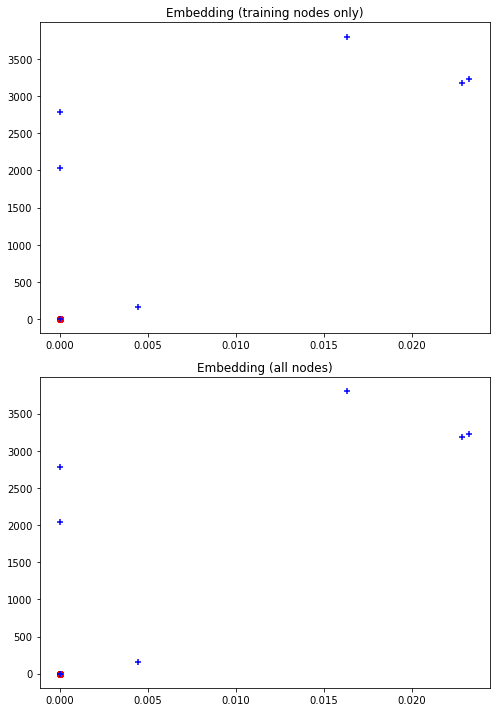

In [28]:
display_embedding(emb_representations_1[-1], nodes_parameters, X_train)

## Build model (hop-distances features)

In [29]:
# Fix seed for reproducibility
np_seed(8)
mxn_seed(8)

In [30]:
# Build model
model2, emb_model2 = build_model(edges_parameters['adjacency_matrix'], X2_comb)

In [31]:
emb_representations_2 = train(model2, emb_model2, X2_comb, X_train, Y_train, epochs = 500)

Epoch 25/500 -- Loss:  9.7469
Epoch 50/500 -- Loss:  9.7226
Epoch 75/500 -- Loss:  9.6884
Epoch 100/500 -- Loss:  9.6791
Epoch 125/500 -- Loss:  9.7056
Epoch 150/500 -- Loss:  9.7381
Epoch 175/500 -- Loss:  9.7510
Epoch 200/500 -- Loss:  9.7519
Epoch 225/500 -- Loss:  9.7503
Epoch 250/500 -- Loss:  9.7339
Epoch 275/500 -- Loss:  9.6998
Epoch 300/500 -- Loss:  9.6774
Epoch 325/500 -- Loss:  9.6897
Epoch 350/500 -- Loss:  9.6585
Epoch 375/500 -- Loss:  5.0444
Epoch 400/500 -- Loss:  2.1393
Epoch 425/500 -- Loss:  0.0661
Epoch 450/500 -- Loss:  0.0516
Epoch 475/500 -- Loss:  0.0246
Epoch 500/500 -- Loss:  0.0086


In [32]:
Y_pred2 = predict(model2, X2_comb, X_test)
print(classification_report(Y_test, Y_pred2))

              precision    recall  f1-score   support

           0       0.83      1.00      0.91        10
           1       1.00      0.80      0.89        10

    accuracy                           0.90        20
   macro avg       0.92      0.90      0.90        20
weighted avg       0.92      0.90      0.90        20



---


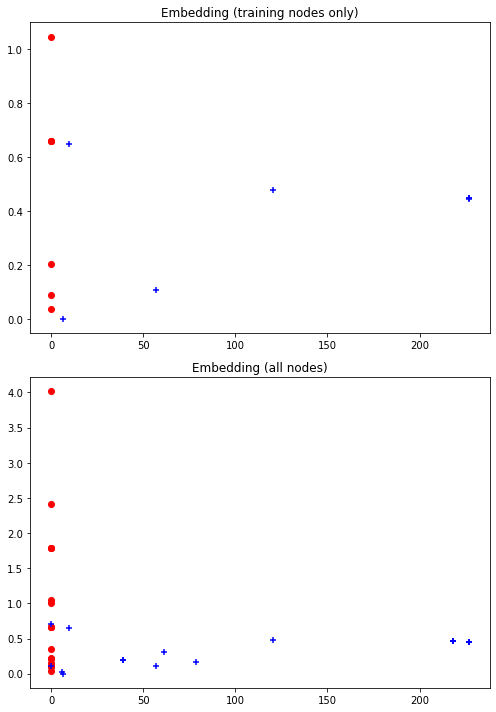

In [33]:
display_embedding(emb_representations_2[-1], nodes_parameters, X_train)